### Hierarchical  Linear Model

I am using a small sample of wheat farms here so as to compute quickly. I am also not considering climate region as the upper level of the hierarchy but simply all wheat fields. Therefore, farm is the lower level and wheat is the upper.

In [3]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from theano import tensor as tt
import seaborn as sns
import scipy

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

/home/brinkerhoff/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
#### wheat data ####
###### mini #######

datapath = 'stripped_mini_maxseason_labeled_df_23.csv'
df = pd.read_csv(datapath)

farm_idx = df.pixel.values.astype(int)
unique_farm_idx = np.unique(farm_idx)
N_farms = pd.unique(df.pixel).size

print ("unique number of farms: \n", N_farms)
print ("\naverage observations per farm: \n", np.round(farm_idx.size/N_farms,1))

unique number of farms: 
 164

average observations per farm: 
 5.9


In [6]:
#####################################
# reindexing pixels from 0-Nfarms
#####################################

zero_farm_idx = np.zeros_like(farm_idx)

for i,farm in enumerate(unique_farm_idx):
        for j in np.where(farm_idx == farm): 
            zero_farm_idx[j] = i      



In [7]:
##########################################################
# This keeps order only becuase df is sorted by farm_idx
#########################################################

df['farm'] = zero_farm_idx
#df.farm.head(10)

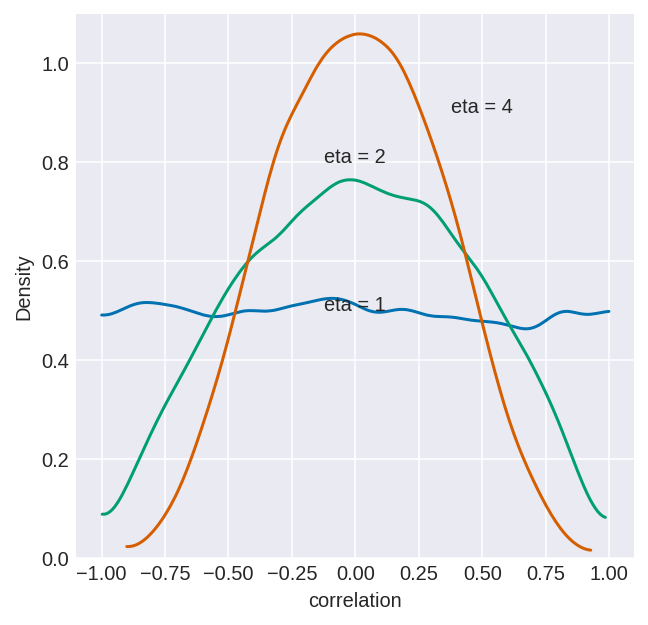

In [8]:
##########################
## corr prior analysis  ##
#########################

_, ax = plt.subplots(1, 1, figsize=(5, 5))
textloc = [[0, .5], [0, .8], [.5, .9]]
for eta, loc in zip([1, 2, 4], textloc):
    R = pm.LKJCorr.dist(n=2, eta=eta).random(size=10000)
    pm.kdeplot(R, ax=ax);
    ax.text(loc[0], loc[1], 'eta = %s'%(eta), horizontalalignment='center')

ax.set_ylim(0, 1.1)
ax.set_xlabel('correlation')
ax.set_ylabel('Density');

The following code implements this model:
$$
P(\vec{w},\bar{w},\bar{\Sigma}\;|\; \vec{NDVI},\vec{VPD}) \propto \left[\prod_{i=1}^N P(NDVI_i|w_i,VPD_i) P(w_i|\bar{w},\bar{\Sigma})\right] P(\bar{w},\bar{\Sigma})
$$
where
$$
P(\bar{w},\bar{\Sigma}) = \mathcal{N}(w_0,\Sigma_w) \mathcal{LKJ}(\eta,\sigma_0)
$$
$$
P(w_i|\bar{w},\bar{\Sigma}) = \mathcal{N}(\bar{w},\bar{\Sigma})
$$
$$
P(NDVI_i|w_i,VPD_i) = \mathcal{N}(w_{i,0} + w_{i,1} VPD_i,\sigma_{NDVI}),
$$
with hyperparameters $\eta$ (prior correlation strength), $\sigma_0$ (prior standard deviation), $w_0=0$ (prior coefficient mean), $\Sigma_w$ (prior coefficient covariance), $\sigma_{NDVI}$ (NDVI measurement uncertainty).  Note that we are assuming independence between individual observations, so we have that
$$
P(NDVI_i|w_i,VPD_i) = \prod_{j=1}^m P(NDVI_{ij}|w_i,VPD_{ij}) = \prod_{j=1}^m \mathcal{N}(w_{i,0} + w_{i,1} VPD_{ij},\sigma_{NDVI})
$$

In [16]:
with pm.Model() as m_4:
    sd_dist = pm.HalfCauchy.dist(beta=1) 
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=1, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    Sigma_bar = pm.Deterministic('Sigma_bar',tt.dot(chol, chol.T))
    
    w_bar = pm.Normal('w_bar',mu=0,sd=3,shape=2)
    
    sigma_ndvi = pm.InverseGamma('sigma_ndvi',beta=0.2,alpha=2.0)
    
    w_i = pm.MvNormal('w_i',w_bar,Sigma_bar,shape=(N_farms,2))
    NDVI_pred = df.zprsum3.values*w_i[:,1][zero_farm_idx] + w_i[:,0][zero_farm_idx]
    NDVI_i = pm.StudentT('NDVI_i',1,mu=NDVI_pred,sd=sigma_ndvi, observed=df.zNDVIsum3)

/home/brinkerhoff/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/brinkerhoff/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [19]:
with m_4:
    trace_4 = pm.sample(3000, tune=300)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/brinkerhoff/.local/lib/python3.6/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/brinkerhoff/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/brinkerhoff/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional i

/home/brinkerhoff/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


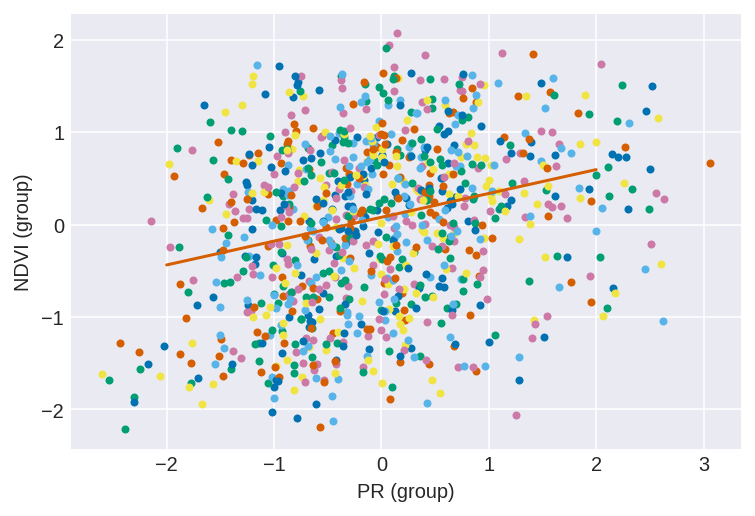

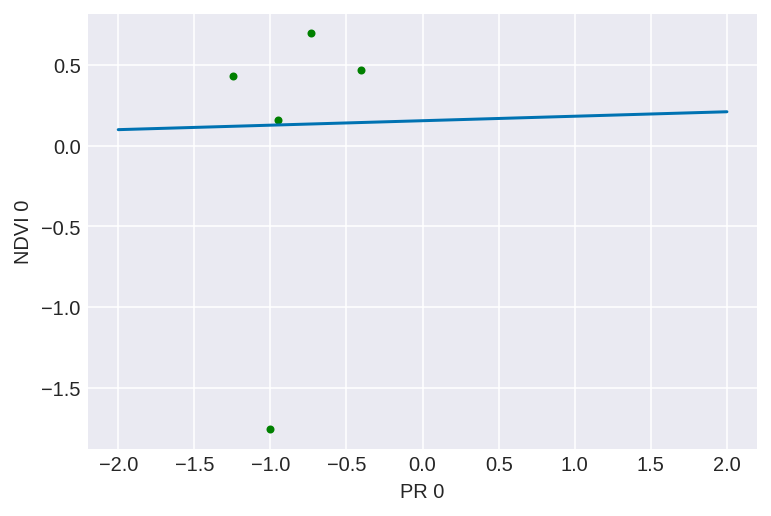

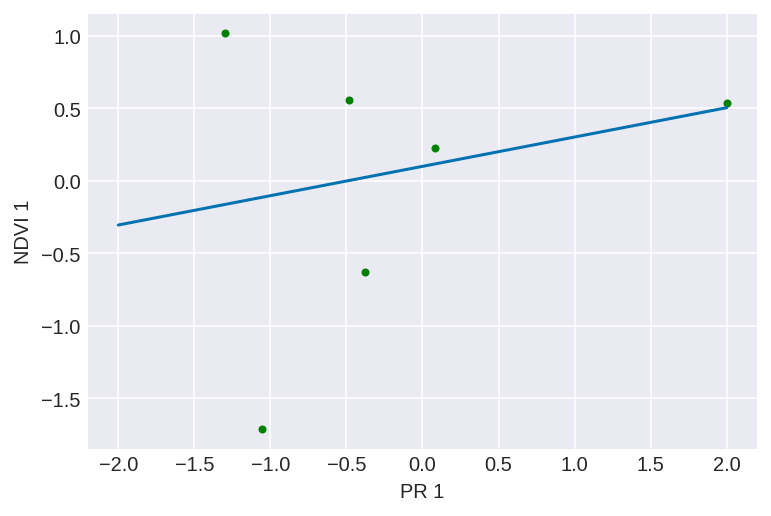

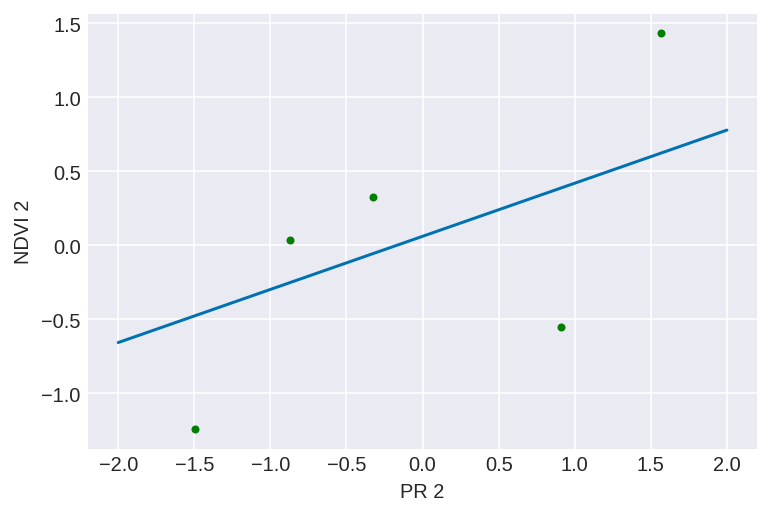

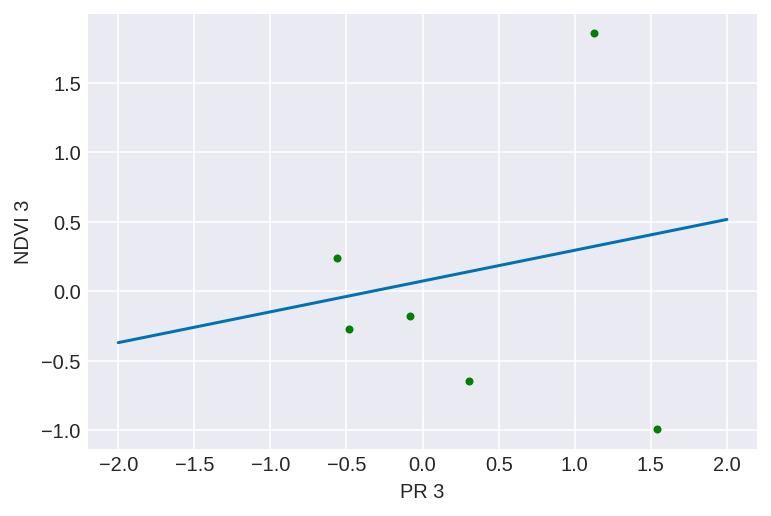

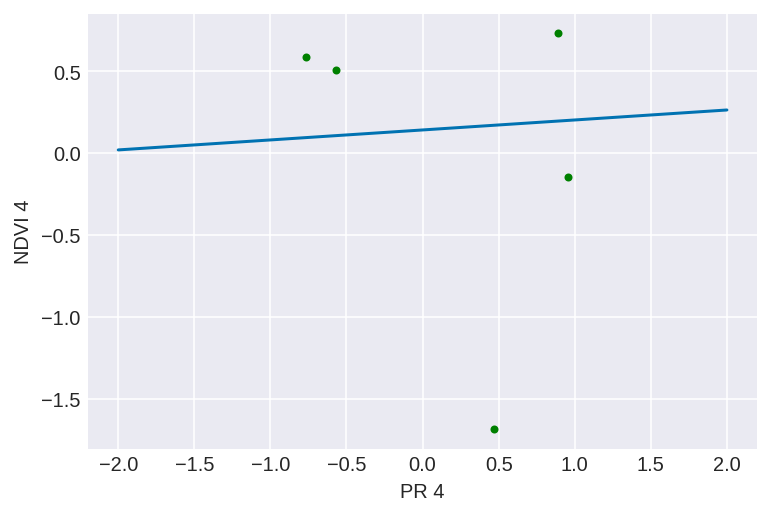

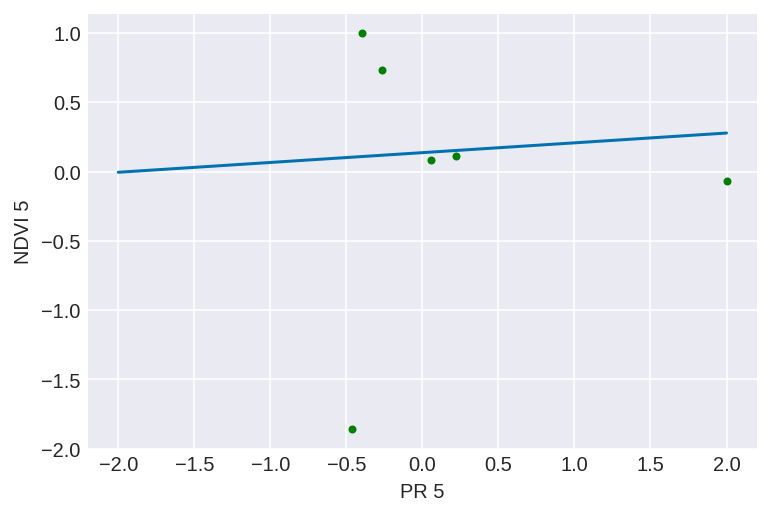

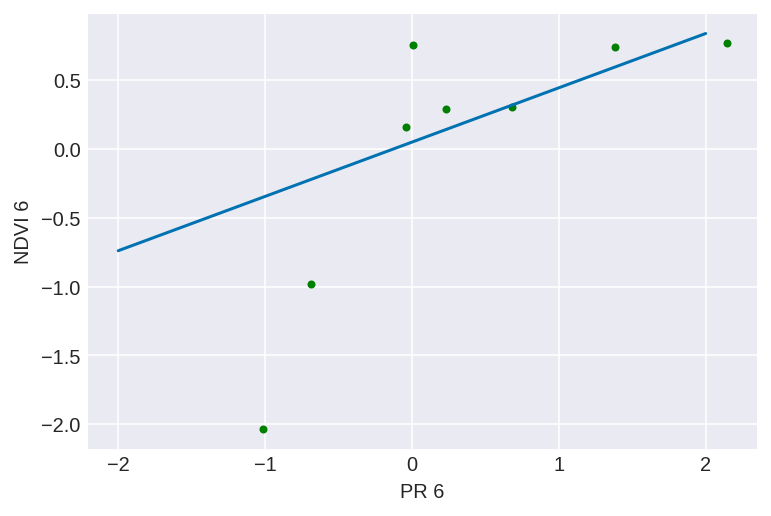

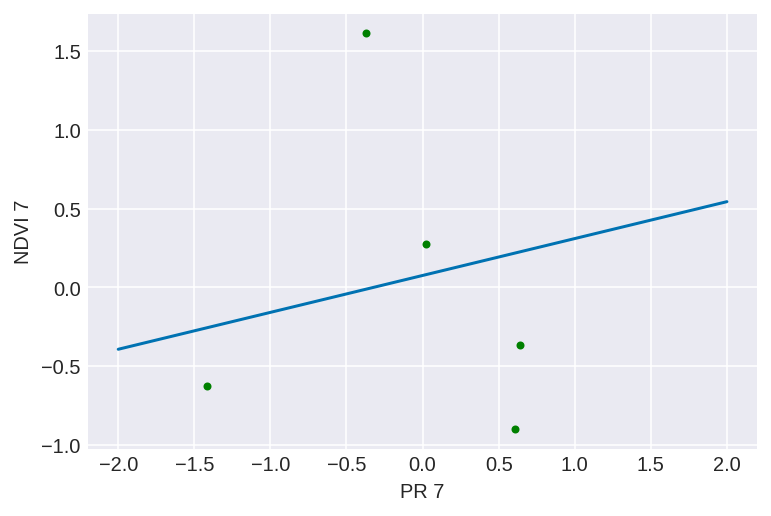

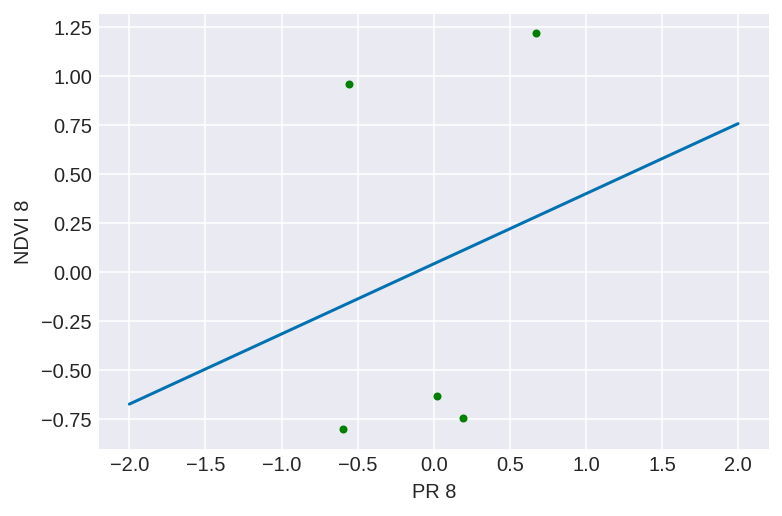

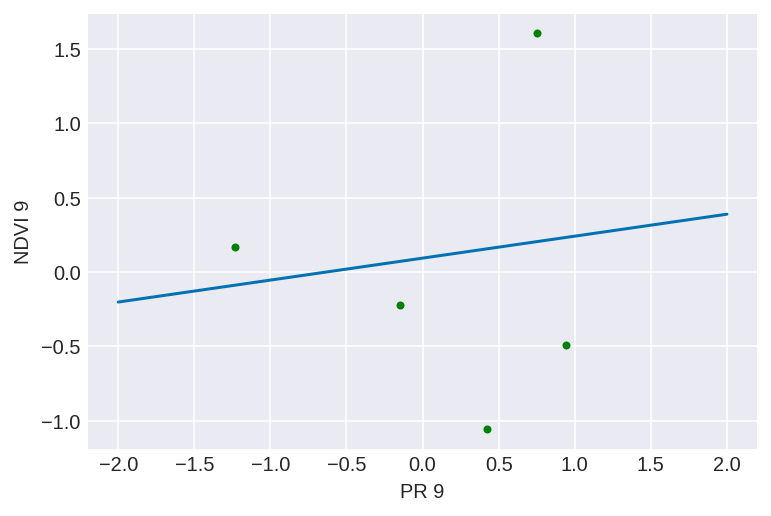

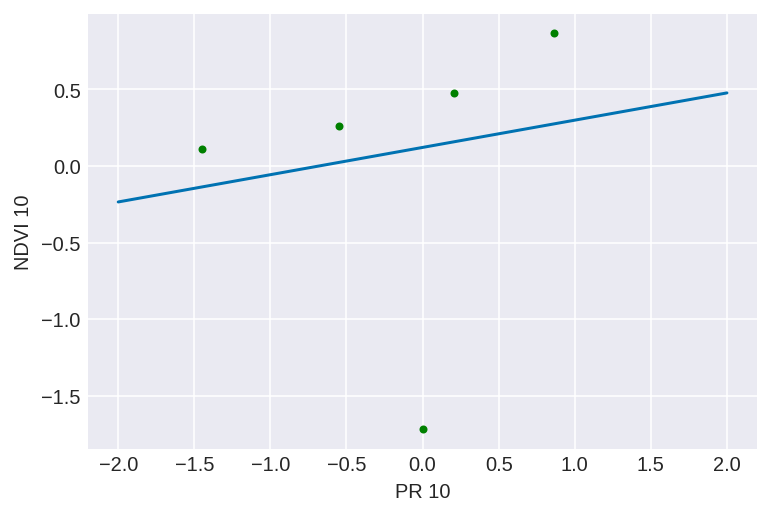

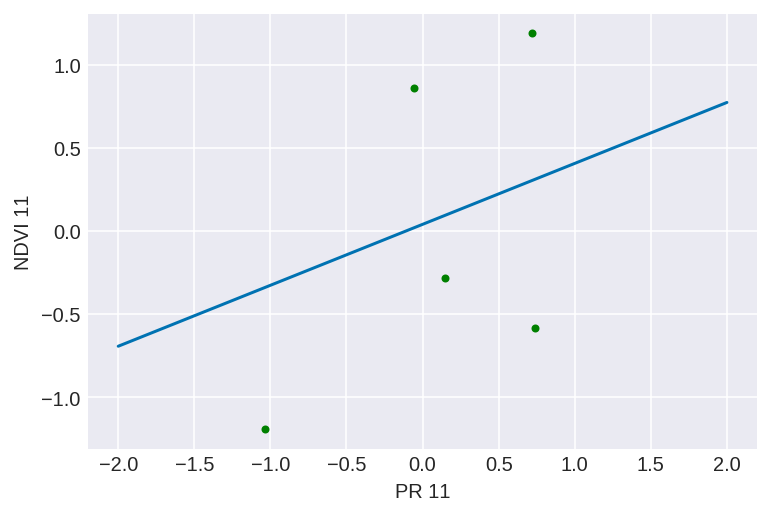

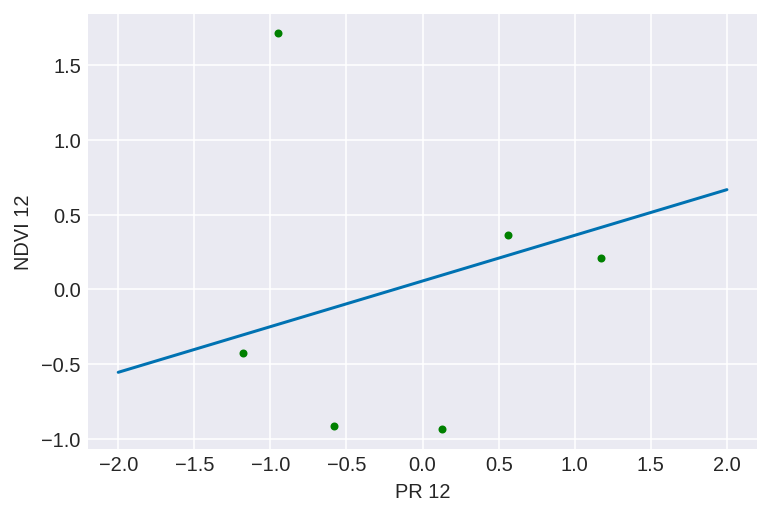

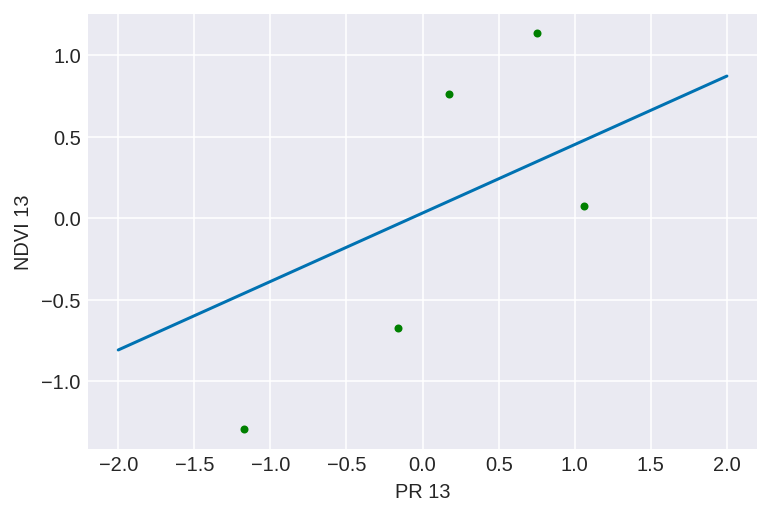

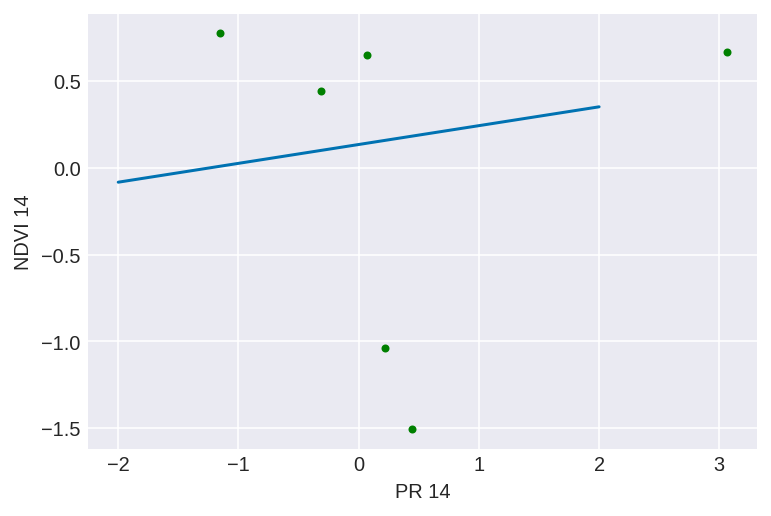

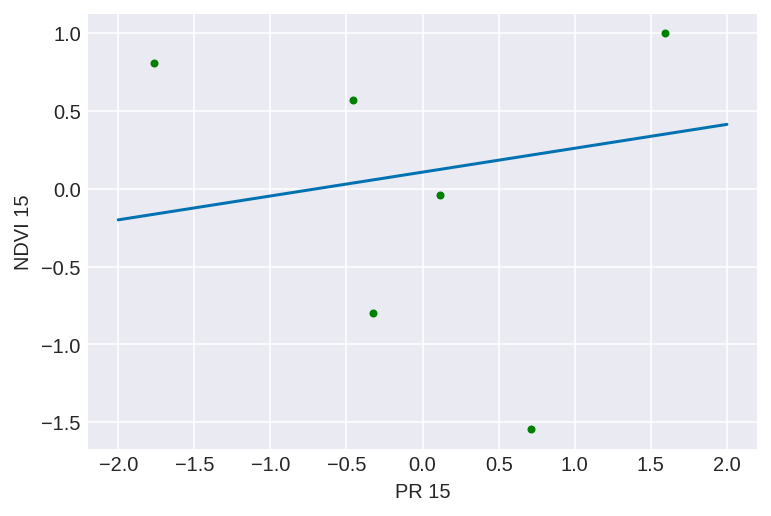

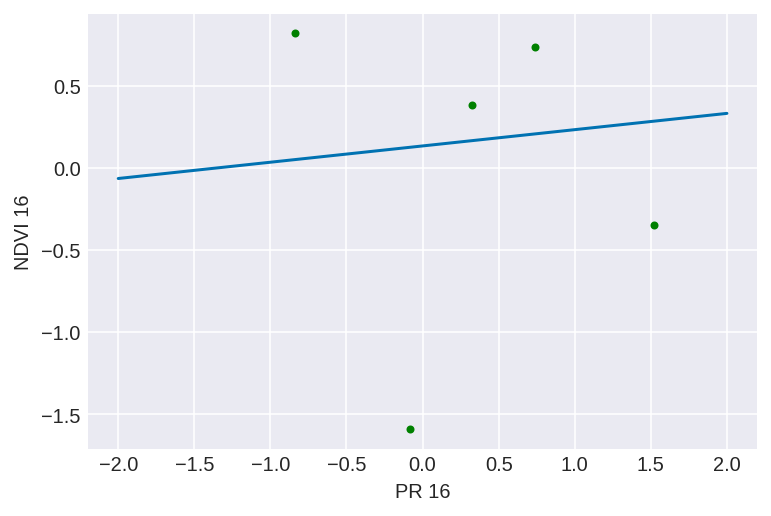

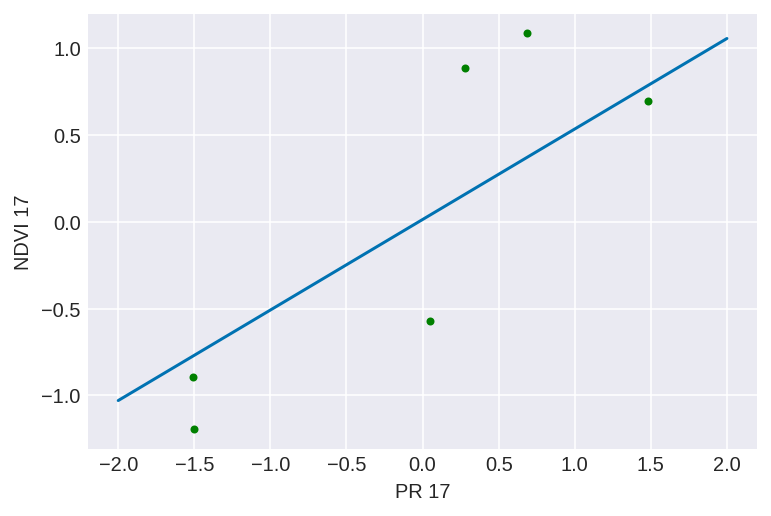

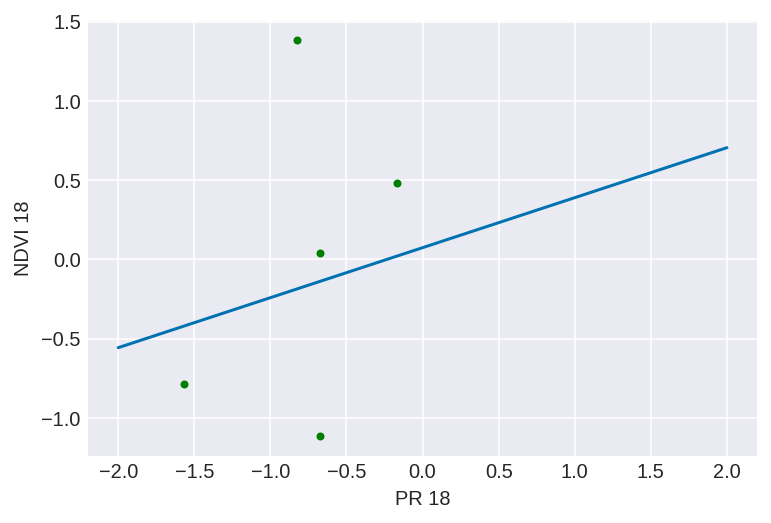

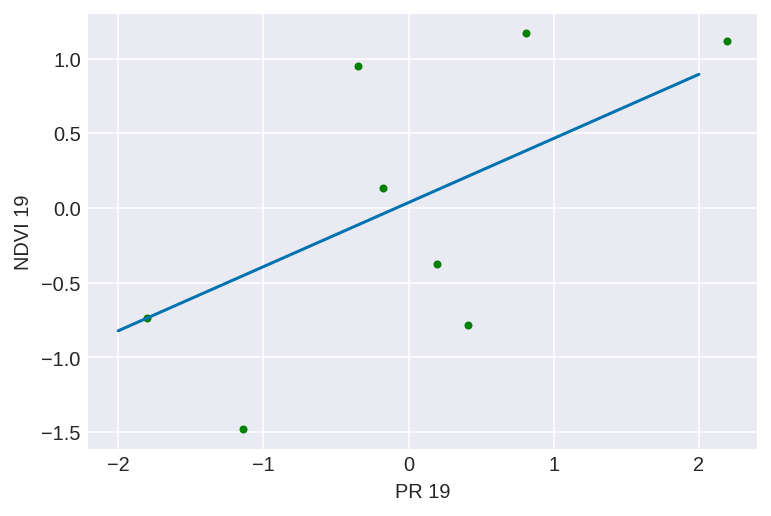

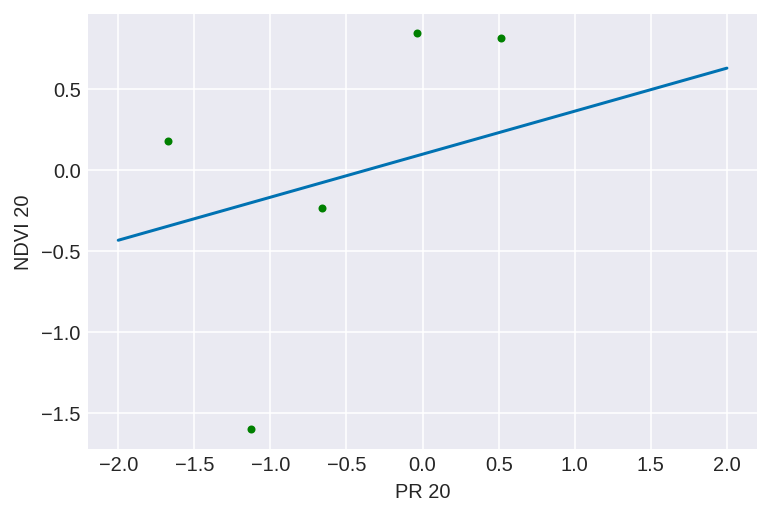

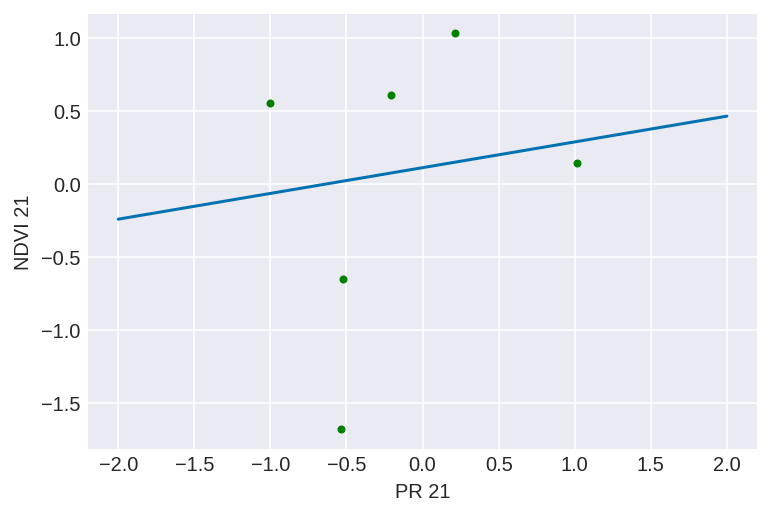

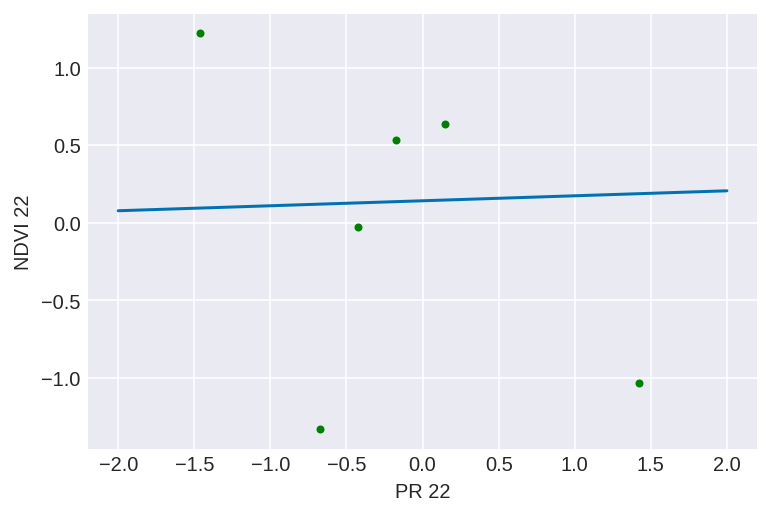

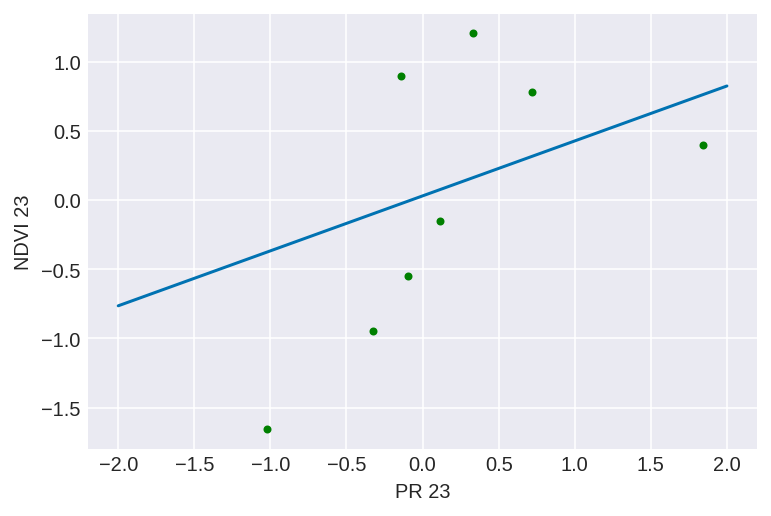

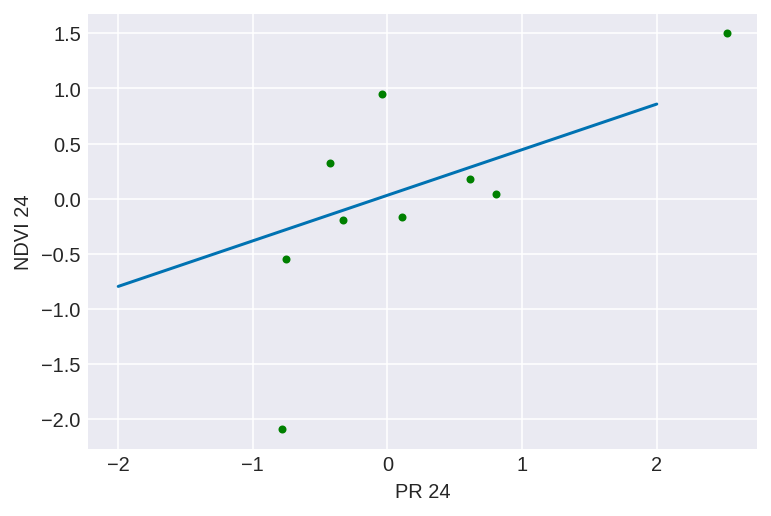

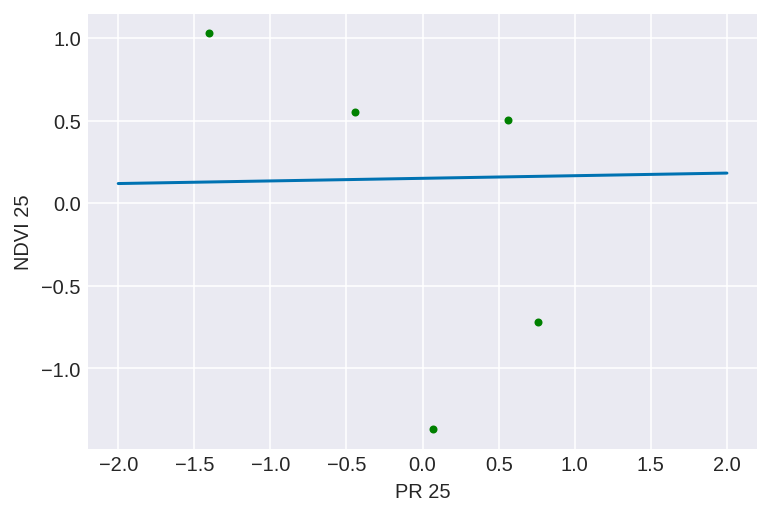

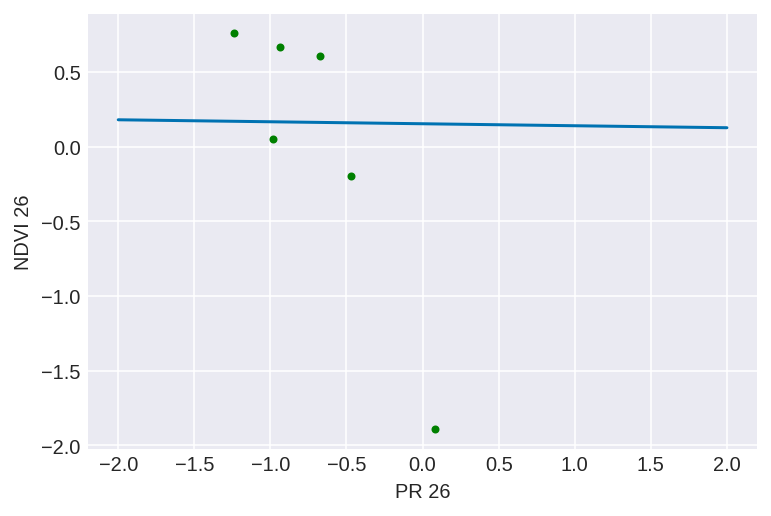

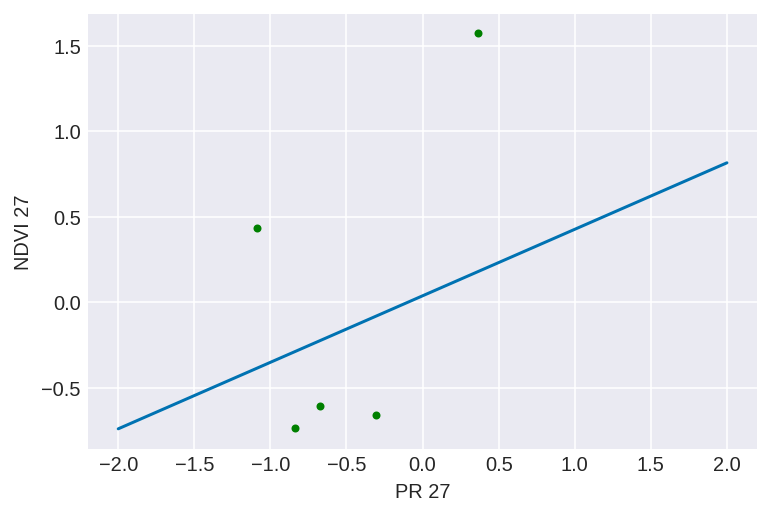

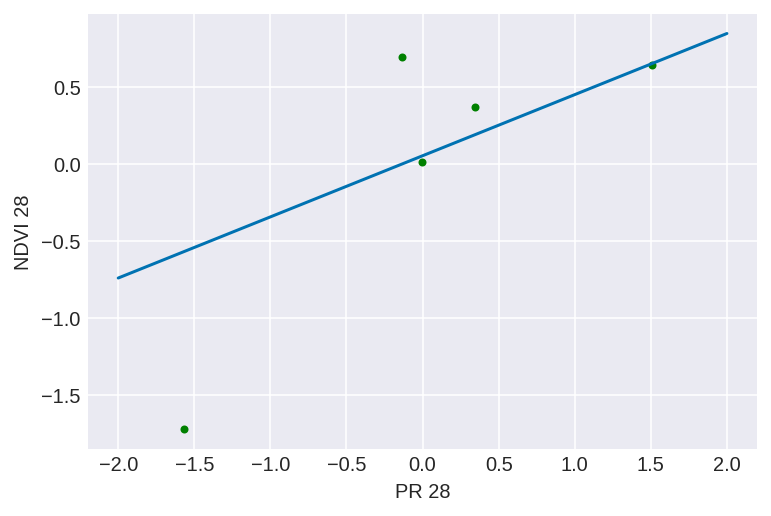

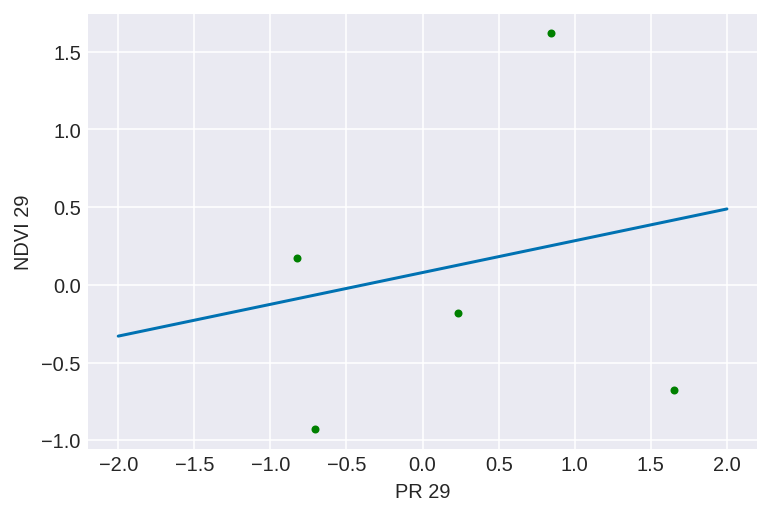

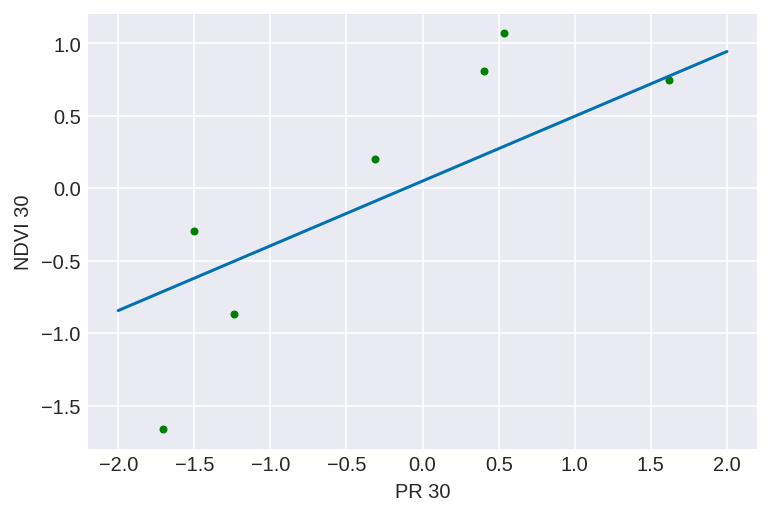

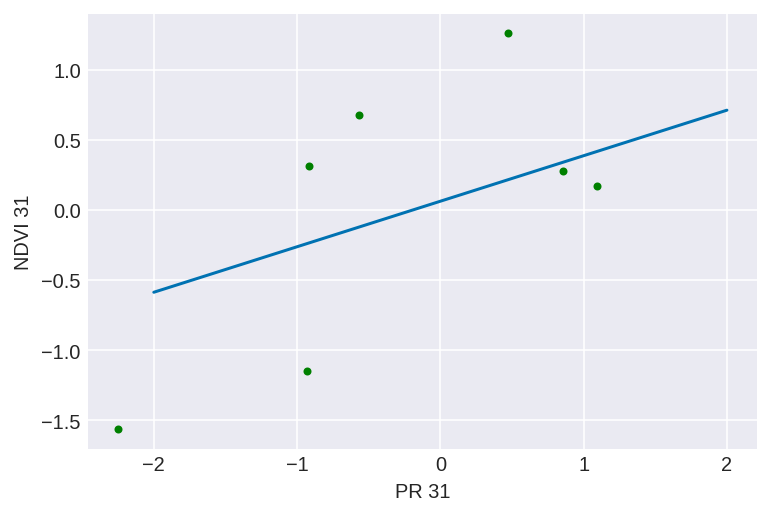

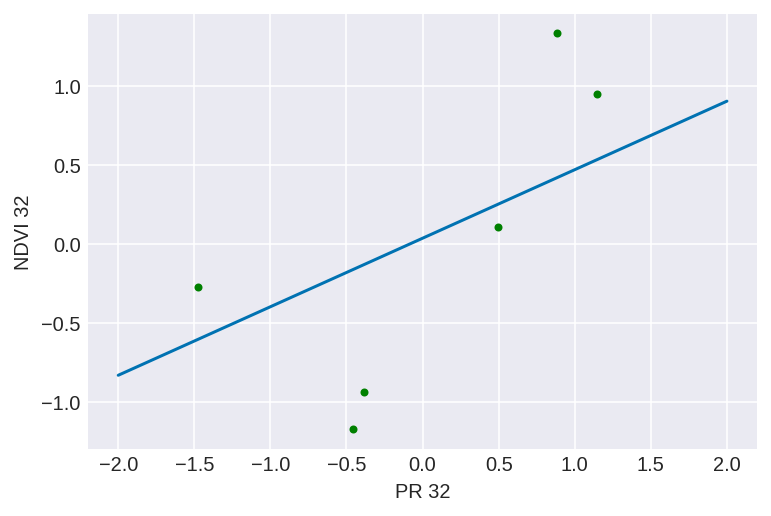

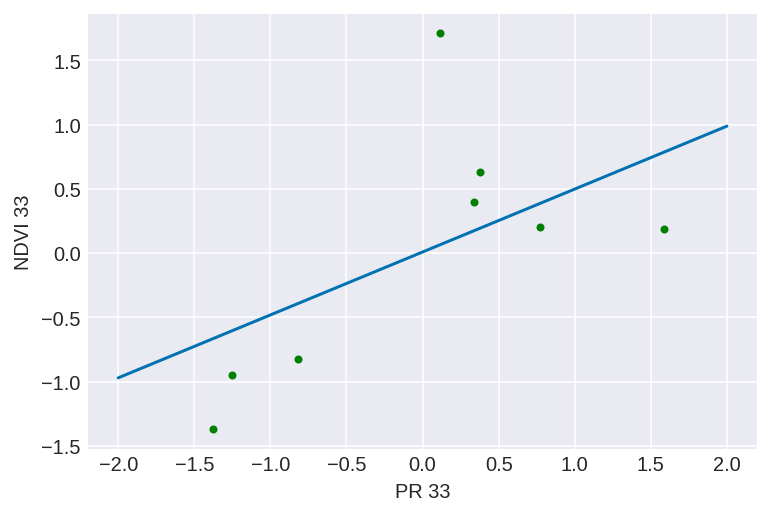

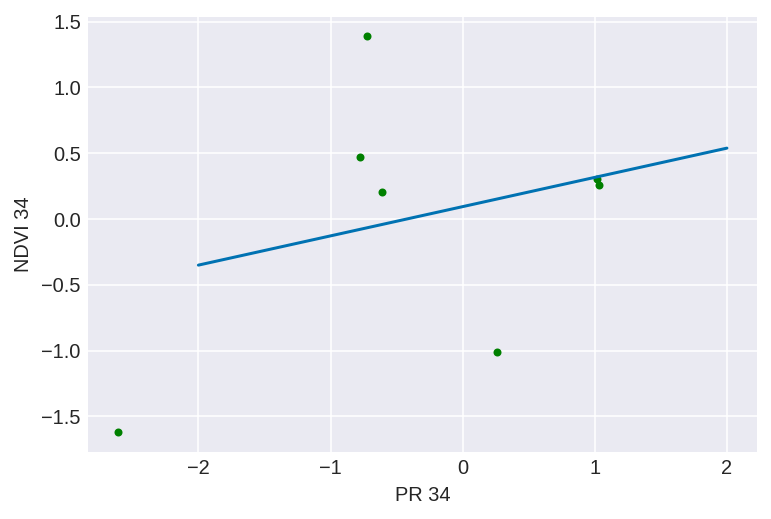

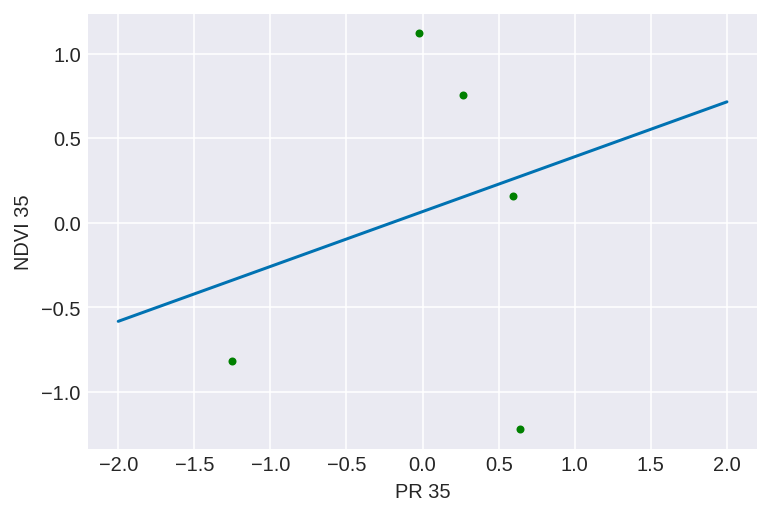

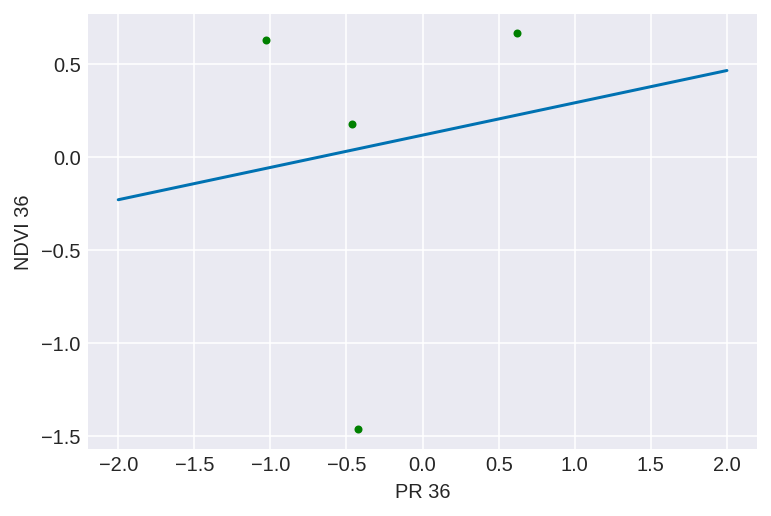

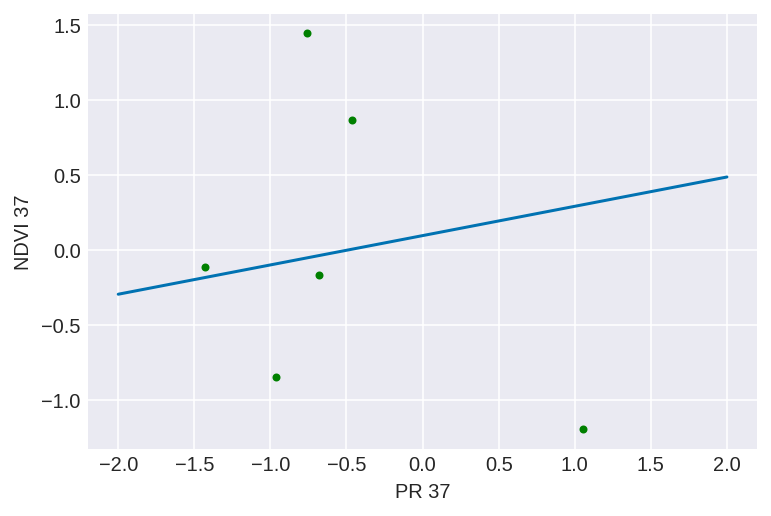

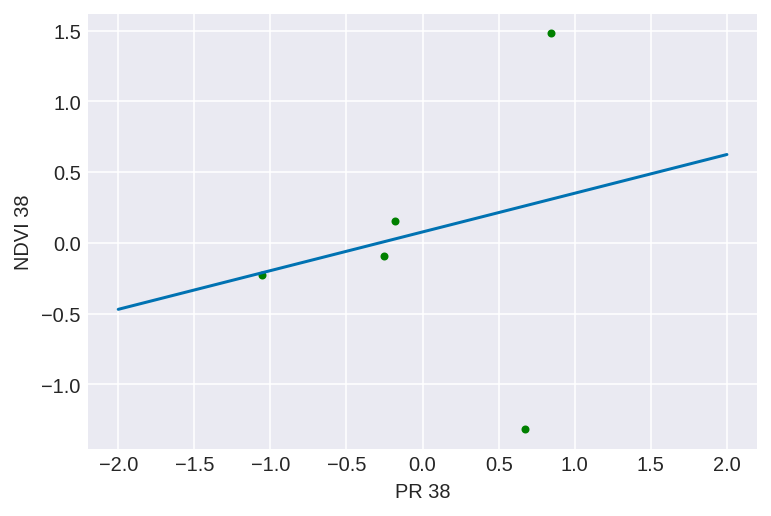

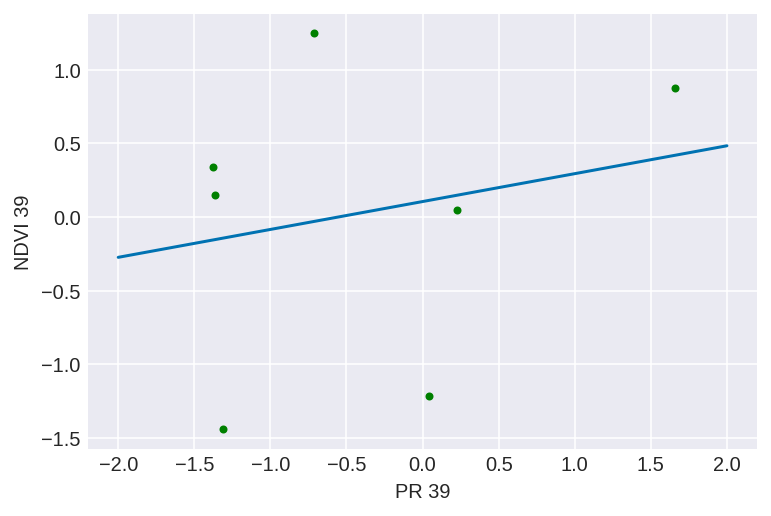

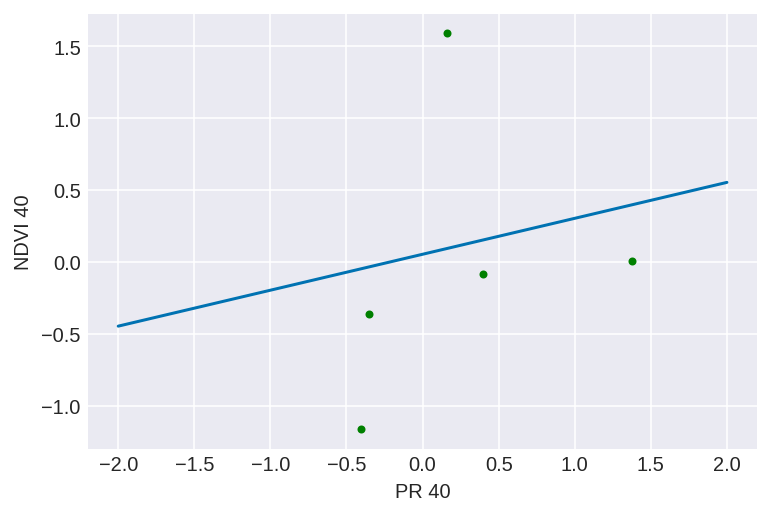

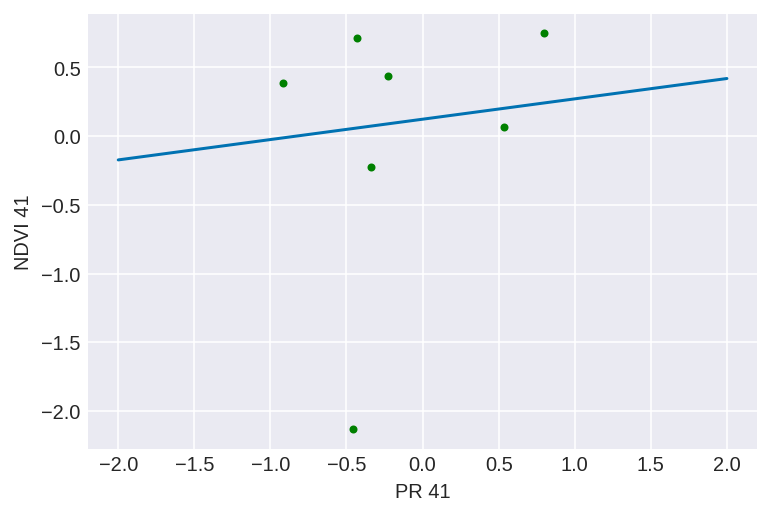

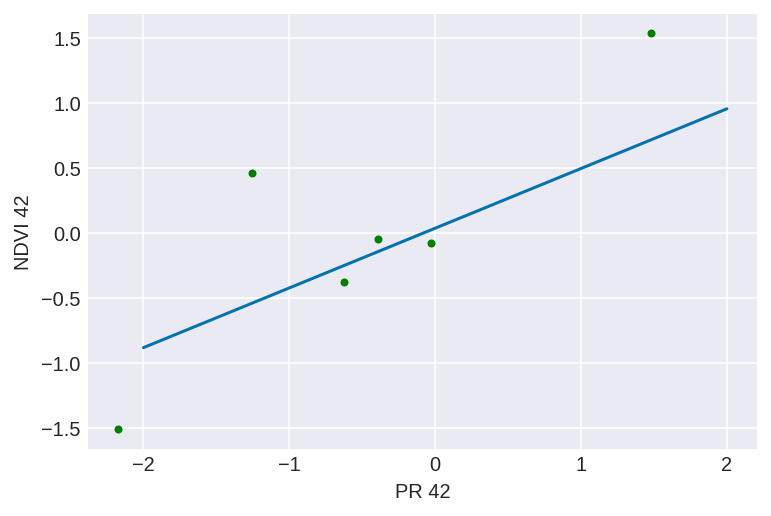

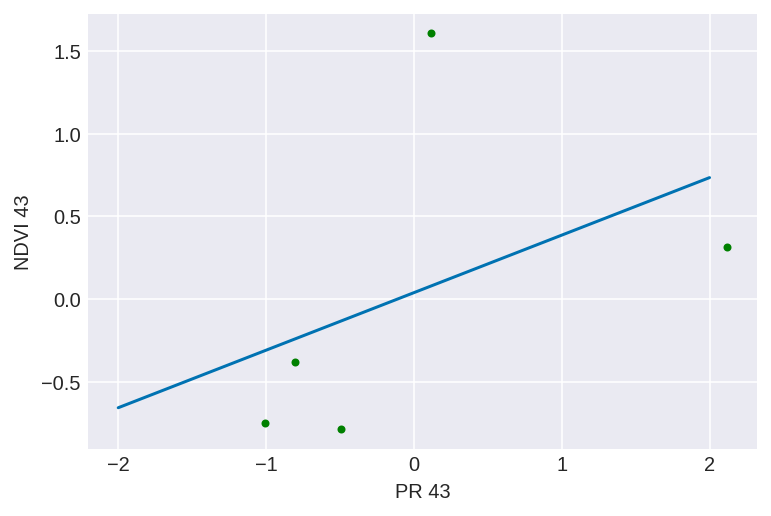

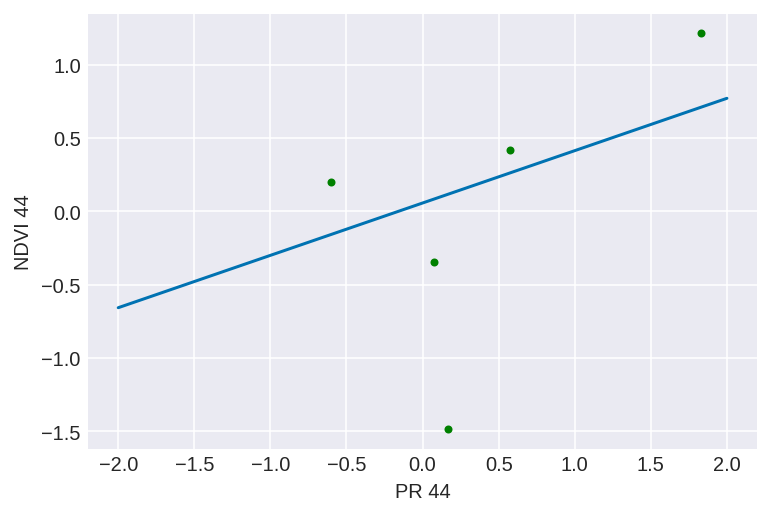

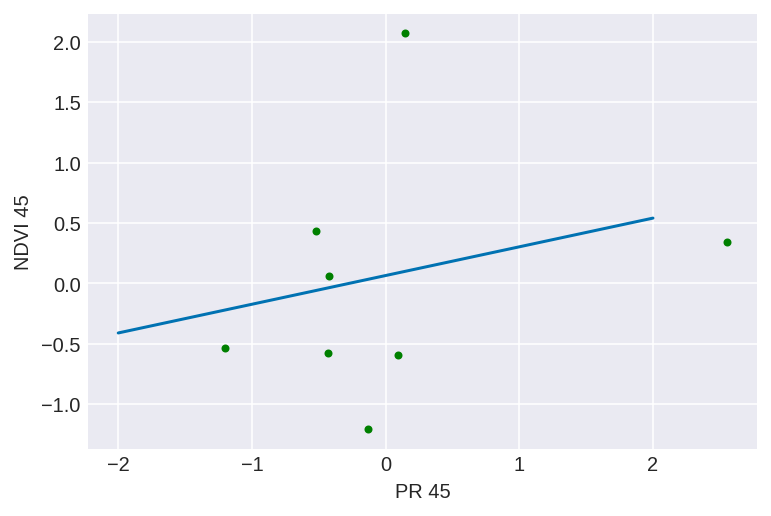

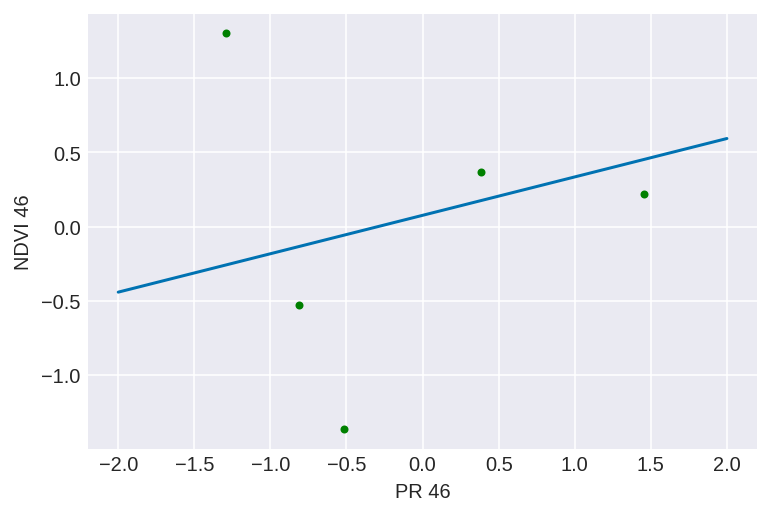

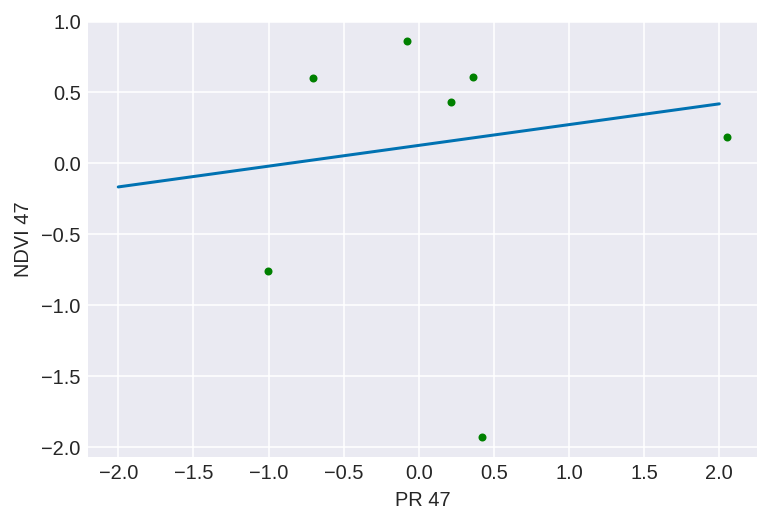

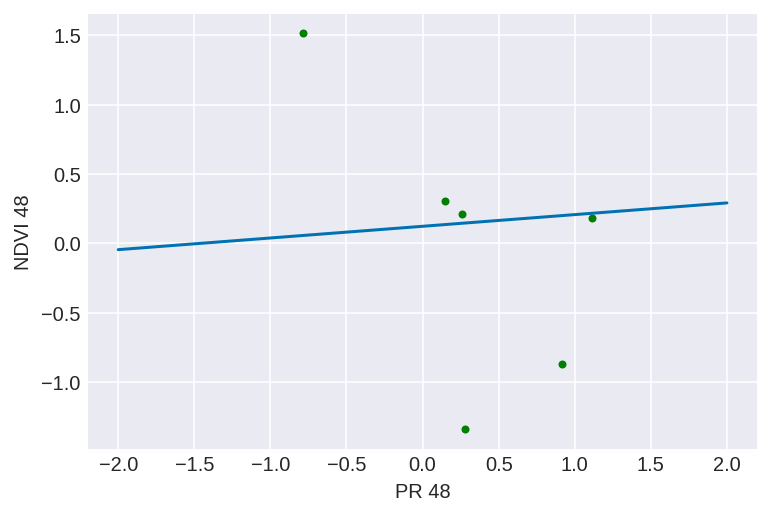

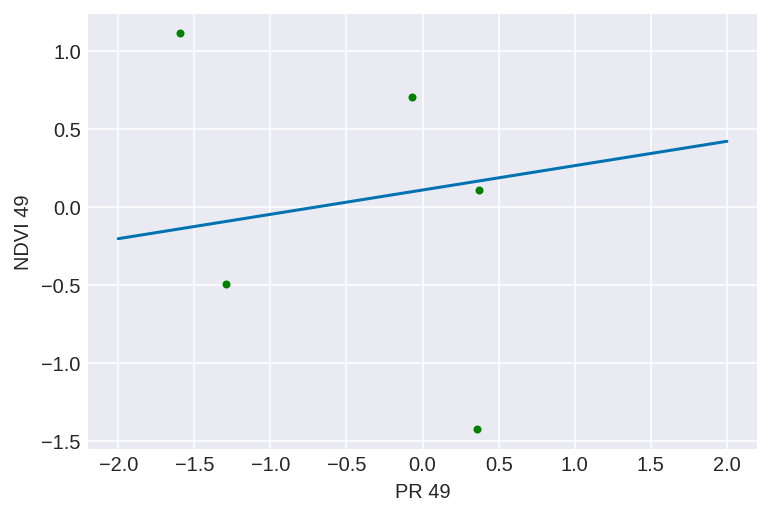

In [20]:
plt.close('all')

plt.figure()
for i in range(N_farms):
    plt.plot(df.zprsum3.values[zero_farm_idx==i],df.zNDVIsum3[zero_farm_idx==i],'.')
w = trace_4.get_values('w_bar').mean(axis=0)
x = np.linspace(-2,2,101)
plt.plot(x,w[0] + w[1]*x)
plt.xlabel('PR (group)')
plt.ylabel('NDVI (group)')

for i in range(50):
    plt.figure()
    plt.plot(df.zprsum3.values[zero_farm_idx==i],df.zNDVIsum3[zero_farm_idx==i],'g.')
    w = trace_4.get_values('w_i').mean(axis=0)[i]
    x = np.linspace(-2,2,101)
    plt.plot(x,w[0] + w[1]*x)
    plt.xlabel('PR '+str(i))
    plt.ylabel('NDVI '+str(i))


/home/brinkerhoff/.local/lib/python3.6/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6ecfed8a20>,
      dtype=object)

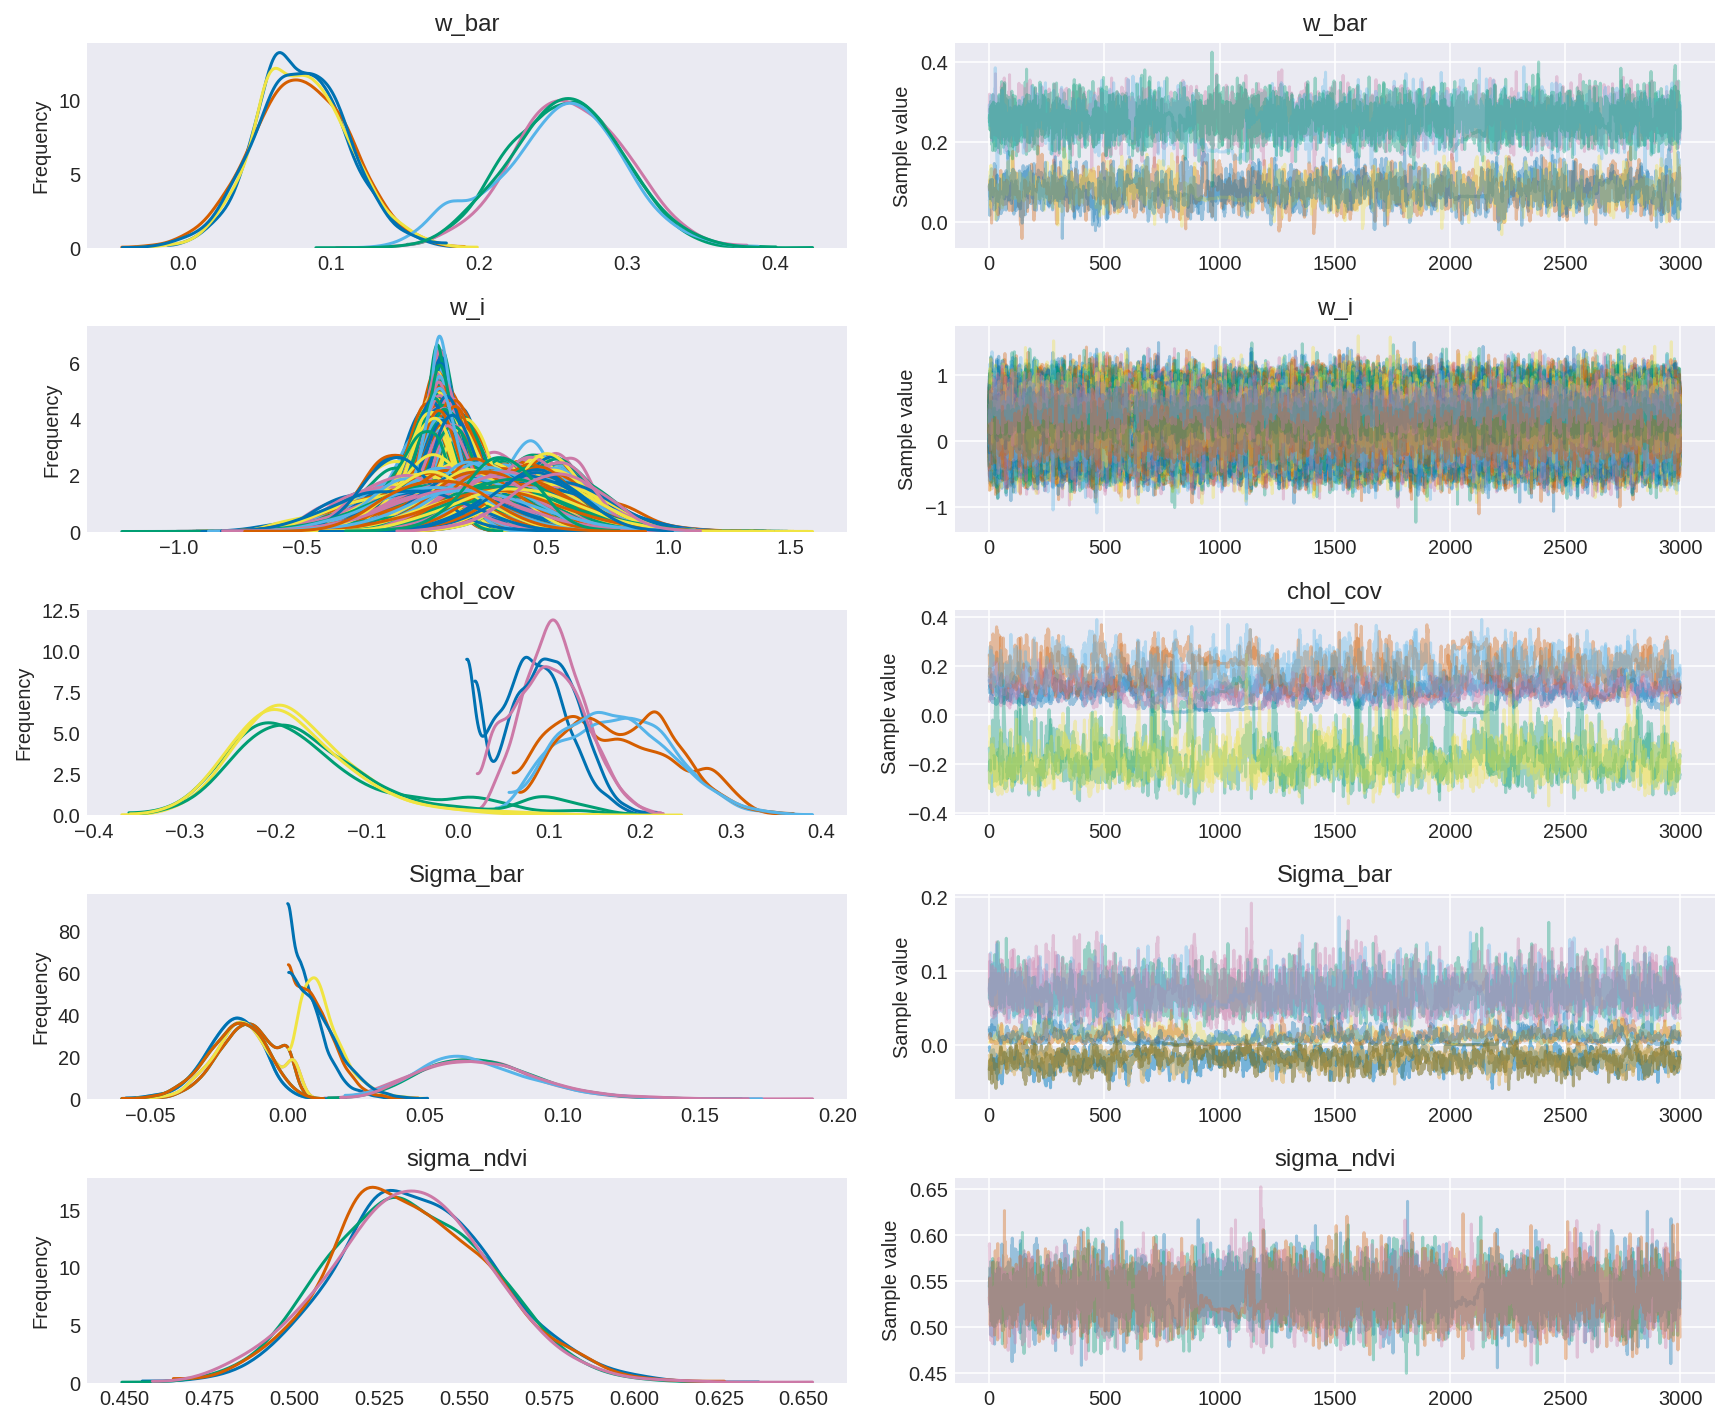

In [23]:
pm.traceplot(trace_4)

In [30]:
pm.InverseGamma?

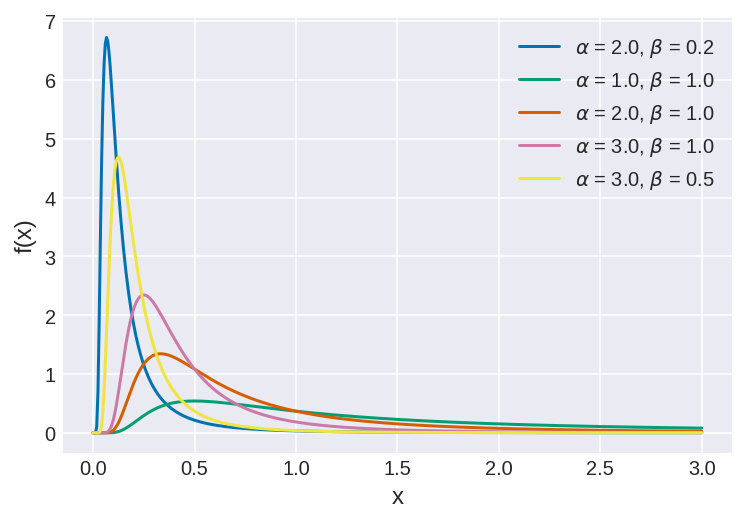

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
plt.style.use('seaborn-darkgrid')
x = np.linspace(0, 3, 500)
alphas = [2., 1., 2., 3., 3.]
betas = [.2, 1., 1., 1., .5]
for a, b in zip(alphas, betas):
    pdf = st.invgamma.pdf(x, a, scale=b)
    plt.plot(x, pdf, label=r'$\alpha$ = {}, $\beta$ = {}'.format(a, b))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()